In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAexGothic')
plt.style.use("ggplot")
import japanize_matplotlib

from pydataset import data
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import PredefinedSplit
from scipy.stats import chi2

In [2]:
# UScrime データの読み込み
usc = data("UScrime")        # MASS::UScrime 相当のデータフレーム
usc = usc.dropna()           # 念のため欠損を落とす

# R:
# X <- UScrime[,-c(2,16)]; M <- ncol(X)
# y <- UScrime[,16]; N <- length(y)
X_df = usc.drop(usc.columns[[1, 15]], axis=1)   # 0-based: 2番目, 16番目列を除く
y = usc.iloc[:, 15].to_numpy(dtype=float)       # 16番目列を目的変数として使用
X = X_df.to_numpy(dtype=float)
N, M = X.shape

In [6]:
# 実行例6.1: リッジ回帰 + GCV で λ を選択
lambdas = np.linspace(0, 5, 50)   # λ候補

# 　標準化
X_mean = X.mean(axis=0)
X_sd   = X.std(axis=0, ddof=1)   # R の sd と合わせて ddof=1
X_std  = (X - X_mean) / X_sd

y_mean = y.mean()
yc = y - y_mean                  # y は中心化のみ（R に合わせる）

S = X_std.T @ X_std

best_gcv = np.inf
best = {}

for lam in lambdas:
    A = S + lam * np.eye(M)
    beta_std = np.linalg.solve(A, X_std.T @ yc)   # 標準化スケールでの係数

    # ハット行列のトレース（自由度）
    A_inv = np.linalg.inv(A)
    # H = X_std (S + λI)^-1 X_std^T → tr(H) = tr(A^-1 S)
    trH = np.trace(A_inv @ S)

    # 予測値（元スケール）に戻す
    beta = beta_std / X_sd
    intercept = y_mean - X_mean @ beta
    y_pred = X @ beta + intercept

    resid = y - y_pred
    rss = np.sum(resid**2)

    gcv = (rss / N) / (1.0 - trH / N) ** 2

    if gcv < best_gcv:
        best_gcv = gcv
        best = {
            "lam": lam,
            "beta_std": beta_std,
            "beta": beta,
            "intercept": intercept,
            "y_pred": y_pred,
            "rss": rss,
            "trH": trH,
        }

lam = best["lam"]
beta = best["beta"]              # shape (M,)
intercept = best["intercept"]
ypred = best["y_pred"]

print(f"選ばれた λ (ridge) = {lam:.4f}")
print("回帰係数（切片＋β1..βM）:")
print("intercept:", intercept)
print("beta:", beta)


選ばれた λ (ridge) = 2.2449
回帰係数（切片＋β1..βM）:
intercept: -5785.108219373281
beta: [ 7.71513319e+00  1.26585397e+01  5.90453401e+00  3.43136455e+00
  5.82529477e-02  2.30580655e+00 -2.99030912e-01  3.75247463e-01
 -4.29660442e+00  1.35942857e+01  5.78521316e-01  5.23889178e+00
 -3.92747068e+03 -2.54370338e-01]


異常度の閾値 (上位 95.0%) ≈ 0.2119


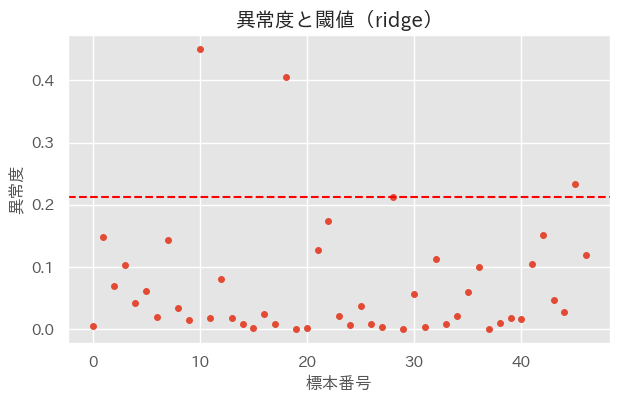

In [7]:
# 実行例6.2: 異常度 a の計算 （式 (6.32) 相当）

# sig2 <- ( lam*sum(coefs[2:15]^2) + sum( as.numeric(ypred) - y)^2 )/N
sig2 = (lam * np.sum(beta**2) + np.sum((ypred - y) ** 2)) / N

# H のトレース: R は X_ = t(scale(X, scale=F)) を使うので Xc と共通
# H については既に trH を計算済み
TrHN = best["trH"] / N

# a <- (as.numeric(ypred) - y)^2/((1 - TrHN)^2*sig2)
a = (ypred - y) ** 2 / ((1.0 - TrHN) ** 2 * sig2)

# 閾値: th <- sort(a)[N*(1-0.05)]
alpha = 0.05
idx_th = int(np.floor(N * (1 - alpha))) - 1  # Rの1-indexを意識
idx_th = max(idx_th, 0)
th = np.sort(a)[idx_th]
print(f"異常度の閾値 (上位 {100*(1-alpha):.1f}%) ≈ {th:.4f}")

# 閾値の線
plt.figure(figsize=(7, 4))
plt.plot(a, "o", ms=4)
plt.axhline(th, color="red", linestyle="--")
plt.xlabel("標本番号")
plt.ylabel("異常度")
plt.title("異常度と閾値（ridge）")
plt.show()


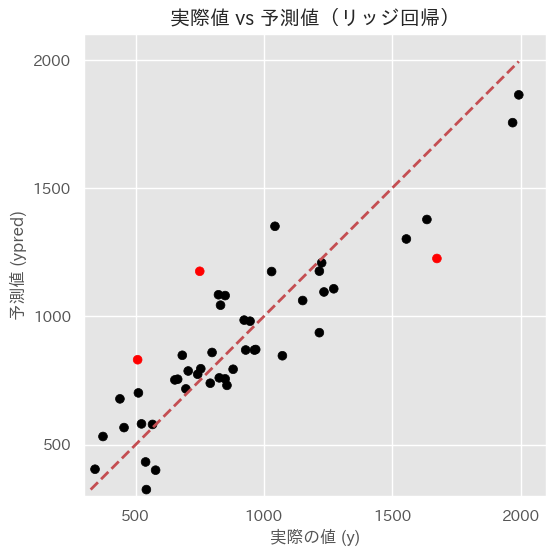

In [8]:
# ==== 実際値 vs 予測値（リッジ回帰） ====
col_vec = np.where(a > th, "red", "black")

plt.figure(figsize=(6, 6))
plt.scatter(y, ypred, c=col_vec, s=40)
plt.xlabel("実際の値 (y)")
plt.ylabel("予測値 (ypred)")
plt.title("実際値 vs 予測値（リッジ回帰）")
# 45度線
ymin = min(y.min(), ypred.min())
ymax = max(y.max(), ypred.max())
plt.plot([ymin, ymax], [ymin, ymax], "r--", linewidth=2)
# 軸の範囲と目盛りを指定
plt.xlim(300, 2100)
plt.ylim(300, 2100)
plt.xticks([500, 1000, 1500, 2000])
plt.yticks([500, 1000, 1500, 2000])
plt.gca().set_aspect("equal", adjustable="box")
plt.show()


=== PLS 回帰 ===
RMSEP (ncomp=1..10): [327.398685954044, 291.4168426354676, 265.1833211400396, 261.10706168100126, 288.21936153401487, 283.2074587063006, 279.04021027951427, 280.74980393738736, 286.28739548431105, 284.9849204580558]
選ばれた PLS 成分数 ncomp = 4
sigma^2_PLS = 35832.52913265287
推定された自由度 df_hat = 1.0973921659269752
閾値 a_th (上側 5%) = 4.077786359990019


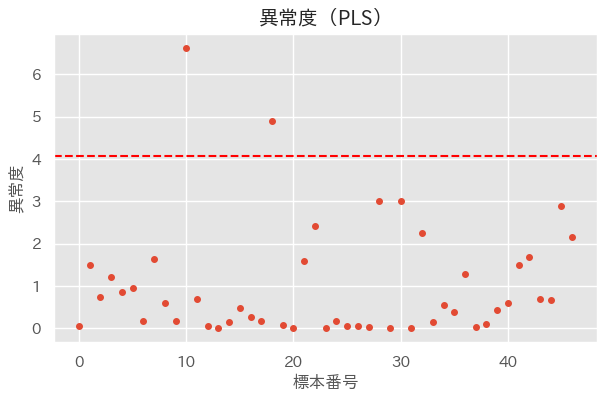

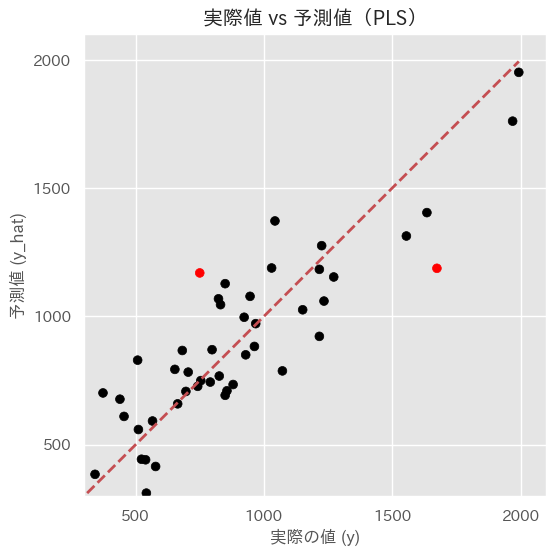

In [9]:
# PLS による異常検知
# dat <- data.frame(y = y, X)
X_pls = X
y_pls = y
N, M = X_pls.shape
# --- 1. CV で成分数 ncomp を選択 ---
# 【Rの再現】R の segments をそのまま Python に（まだ 1 始まり） ====
segments = [
    [31, 5, 34, 13, 32],      # V1
    [15, 38, 19, 21, 6],      # V2
    [14, 28, 4, 36, 1],       # V3
    [3, 9, 41, 30, 2],        # V4
    [42, 29, 17, 18, 47],     # V5
    [37, 44, 11, 16, 24],     # V6
    [45, 8, 33, 22, 40],      # V7
    [25, 39, 12, 43],         # V8
    [26, 7, 46, 20],          # V9
    [27, 10, 35, 23],         # V10
]
folds = -np.ones(N, dtype=int)

for k, idx_list in enumerate(segments):
    for idx in idx_list:
        # R は 1 始まりなので 1 引いて 0 始まりに
        folds[idx - 1] = k
cv_ps = PredefinedSplit(test_fold=folds)
max_comp = min(M, 10)   # 適当に上限（M or 10）を設定
#kf = KFold(n_splits=10, shuffle=True, random_state=123)#通常使用はこちらを使う

rmseps = []
for n_comp in range(1, max_comp + 1):
    # Rと合わせるため：
    #  - X を StandardScaler で標準化
    #  - PLSRegression(scale=False) で X, y をセンタリングのみ
    model = Pipeline([
        ("scaler_x", StandardScaler()),                    # X を標準化
        ("pls", PLSRegression(n_components=n_comp,
                              scale=False, max_iter=500))
    ])
    y_cv = cross_val_predict(model, X_pls, y_pls, cv=cv_ps)#通常はcv=kf
    rmsep = np.sqrt(mean_squared_error(y_pls, y_cv))
    rmseps.append(rmsep)

best_ncomp = 1 + int(np.argmin(rmseps))
print("\n=== PLS 回帰 ===")
print("RMSEP (ncomp=1..{}):".format(max_comp), rmseps)
print("選ばれた PLS 成分数 ncomp =", best_ncomp)

# --- 2. 選ばれた ncomp で PLS を学習 ---
pls_best = PLSRegression(n_components=best_ncomp, scale=True)
pls_best.fit(X_pls, y_pls)
y_hat_train = pls_best.predict(X_pls).ravel()

resid_pls = y_pls - y_hat_train
sigma2_pls = np.mean(resid_pls ** 2)   # 1/N * Σ (y - ŷ)^2
print("sigma^2_PLS =", sigma2_pls)

# --- 3. 異常度 a_i = (y_i - ŷ_i)^2 / sigma2_pls ---
a_train = (y_pls - y_hat_train) ** 2 / sigma2_pls

# --- 4. モーメント法で χ^2 分布に当てはめて閾値 ---
m1 = a_train.mean()             # E[a]
m2 = a_train.var(ddof=1)        # Var[a] (Rのvarと同じ n-1)

df_hat = 2 * m1**2 / m2         # 自由度推定
alpha = 0.05
a_th = chi2.ppf(1 - alpha, df_hat)

print("推定された自由度 df_hat =", df_hat)
print("閾値 a_th (上側 5%) =", a_th)

# --- 5. 訓練サンプルの異常度プロット ---
plt.figure(figsize=(7, 4))
plt.plot(a_train, "o", ms=4)
plt.axhline(a_th, color="red", linestyle="--")
plt.xlabel("標本番号")
plt.ylabel("異常度")
plt.title("異常度（PLS）")
plt.show()

# --- 6. 実際値 vs 予測値（PLS） ---
col_vec_pls = np.where(a_train > a_th, "red", "black")

plt.figure(figsize=(6, 6))
plt.scatter(y_pls, y_hat_train, c=col_vec_pls, s=40)
plt.xlabel("実際の値 (y)")
plt.ylabel("予測値 (y_hat)")
plt.title("実際値 vs 予測値（PLS）")
# 45度線
ymin = min(y_pls.min(), y_hat_train.min())
ymax = max(y_pls.max(), y_hat_train.max())
plt.plot([ymin, ymax], [ymin, ymax], "r--", linewidth=2)
# 軸の範囲と目盛りを指定
plt.xlim(300, 2100)
plt.ylim(300, 2100)
plt.xticks([500, 1000, 1500, 2000])
plt.yticks([500, 1000, 1500, 2000])
plt.gca().set_aspect("equal", adjustable="box")
plt.show()